# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_094  Q9UKB5           16.637
Sample_084  A0A0A0MT36       15.651
Sample_175  Q01995           17.433
Sample_182  A0A0A0MT36       13.422
Sample_035  P68871           16.885
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                 
Sample_142  E7EWD3;O75077;O75077-2;O75077-3   16.035
Sample_055  E7EPV7;P37840;P37840-2            13.628
Sample_004  Q9Y281;Q9Y281-3                   12.652
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.855
            A0A075B6Q5                 12.847
            A0A075B6R2                 13.619
            A0A075B6S5                 12.009
            A0A087WSY4                 14.502
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.595
            Q9UI40;Q9UI40-2            11.827
            Q9UIW2                     12.606
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.714
            Q9UP79                     11.855
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.338,15.050,16.842,19.863,15.689,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.621,19.067,...,15.528,15.576,14.146,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.580,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.950,17.705,17.039,16.178,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.964,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.276,15.345,17.084,18.708,14.249,19.433,12.294,10.993
Sample_207,15.739,16.877,15.469,16.898,15.264,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.337,12.875,13.478,13.099,12.800,13.330,13.162,13.375,13.473,14.113
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.000,19.067,16.127,...,11.359,12.790,12.791,12.384,12.945,12.345,12.820,12.909,12.343,12.745
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.511,12.728,13.137,13.151,13.399,12.974,11.465,13.133,12.425,12.532
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,10.521,12.632,14.061,12.467,11.296,12.997,13.686,12.471,14.749,13.032
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.770,13.435,12.245,12.464,12.408,11.085,12.354,13.670,12.816,13.418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.089,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 392.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]

100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.81it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.26it/s]

100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

100%|██████████| 5/5 [00:01<00:00,  4.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.05it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.41it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.94it/s]

100%|██████████| 6/6 [00:01<00:00,  2.67it/s]

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.48it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.46it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.93it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.86it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.70it/s]

100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.92it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.89it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.43it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.20it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.04it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.28it/s]

100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

100%|██████████| 8/8 [00:03<00:00,  2.40it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.13it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.52it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.61it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.54it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.37it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.25it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.13it/s]

100%|██████████| 9/9 [00:03<00:00,  2.19it/s]

100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.37it/s]

 30%|███       | 3/10 [00:00<00:01,  6.63it/s]

 40%|████      | 4/10 [00:00<00:01,  5.70it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.08it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.94it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.03it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.43it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.52it/s]

100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

100%|██████████| 10/10 [00:02<00:00,  4.97it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.99it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.79it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.74it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.08it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.99it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.72it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.65it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.39it/s]

100%|██████████| 11/11 [00:01<00:00,  5.23it/s]

100%|██████████| 11/11 [00:01<00:00,  6.25it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.98it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.29it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.10it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.20it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.16it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.25it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.20it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.29it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.33it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.13it/s]

100%|██████████| 12/12 [00:02<00:00,  4.07it/s]

100%|██████████| 12/12 [00:02<00:00,  4.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.63it/s]

 23%|██▎       | 3/13 [00:00<00:01,  7.06it/s]

 31%|███       | 4/13 [00:00<00:01,  5.24it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.97it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.69it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.84it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.00it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.11it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.37it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.11it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.95it/s]

100%|██████████| 13/13 [00:03<00:00,  2.96it/s]

100%|██████████| 13/13 [00:03<00:00,  3.65it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.01it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.91it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.57it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.39it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.12it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.86it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.11it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.26it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.41it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.68it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.91it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.14it/s]

100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

100%|██████████| 14/14 [00:03<00:00,  3.70it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.36it/s]

 20%|██        | 3/15 [00:00<00:02,  5.19it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.76it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.61it/s]

 40%|████      | 6/15 [00:01<00:01,  4.60it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.36it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.33it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.35it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.54it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.23it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.12it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.22it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.12it/s]

100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.056 0.030          0.756 0.355       0.114   
2             0.004 0.002      0.043 0.015          0.753 0.079       0.701   
3             0.005 0.007      0.053 0.021          0.746 0.084       0.697   
4             0.005 0.004      0.046 0.016          0.760 0.081       0.722   
5             0.005 0.005      0.049 0.022          0.783 0.079       0.768   
6             0.006 0.005      0.051 0.017          0.786 0.085       0.771   
7             0.004 0.003      0.052 0.020          0.778 0.085       0.763   
8             0.006 0.005      0.052 0.021          0.813 0.079       0.809   
9             0.005 0.006      0.048 0.025          0.818 0.078       0.806   
10            0.004 0.000      0.038 0.008          0.815 0.079       0.809   
11            0.004 0.000      0.038 0.007          0.814 0.082       0.805   
12            0.004 0.002      0.039 0.009          0.808 0.078       0.801   
13            0.006 0.004      0.061 0.023          0.806 0.080       0.795   
14            0.006 0.007      0.049 0.018          0.803 0.084       0.794   
15            0.004 0.000      0.041 0.014          0.793 0.084       0.782   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.191 0.130                  0.550 0.042        0.856   
2          0.119   0.720 0.082                  0.766 0.062        0.859   
3          0.108   0.715 0.076                  0.760 0.059        0.855   
4          0.105   0.735 0.074                  0.776 0.058        0.857   
5          0.094   0.772 0.067                  0.805 0.056        0.870   
6          0.094   0.774 0.068                  0.807 0.056        0.901   
7          0.102   0.766 0.075                  0.801 0.060        0.898   
8          0.096   0.807 0.068                  0.835 0.058        0.908   
9          0.095   0.809 0.069                  0.837 0.059        0.908   
10         0.099   0.808 0.070                  0.836 0.060        0.907   
11         0.100   0.806 0.072                  0.834 0.061        0.905   
12         0.103   0.800 0.072                  0.830 0.060        0.906   
13         0.106   0.796 0.074                  0.827 0.062        0.906   
14         0.106   0.794 0.075                  0.825 0.064        0.905   
15         0.099   0.783 0.071                  0.815 0.060        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.825 0.091        210.000 0.000  
2          0.053                  0.834 0.065        210.000 0.000  
3          0.051                  0.829 0.062        210.000 0.000  
4          0.047                  0.829 0.058        210.000 0.000  
5          0.051                  0.839 0.067        210.000 0.000  
6          0.048                  0.878 0.057        210.000 0.000  
7          0.048                  0.873 0.059        210.000 0.000  
8          0.048                  0.891 0.052        210.000 0.000  
9          0.048                  0.891 0.051        210.000 0.000  
10         0.049                  0.890 0.053        210.000 0.000  
11         0.049                  0.887 0.054        210.000 0.000  
12         0.049                  0.891 0.053        210.000 0.000  
13         0.049                  0.891 0.053        210.000 0.000  
14         0.051                  0.890 0.054        210.000 0.000  
15         0.050                  0.885 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 483.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.34it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.09it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.54it/s]

100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.78it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.96it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.28it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

100%|██████████| 6/6 [00:01<00:00,  4.28it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.73it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.50it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.79it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.31it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.86it/s]

100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.77it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.23it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.70it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.78it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.86it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.64it/s]

100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.49it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.80it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.13it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.74it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.79it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.83it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.61it/s]

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.06it/s]

 30%|███       | 3/10 [00:00<00:01,  6.07it/s]

 40%|████      | 4/10 [00:00<00:01,  4.93it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.34it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.17it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.08it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.48it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.46it/s]

100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

100%|██████████| 10/10 [00:02<00:00,  4.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.04it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.79it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.92it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.84it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.77it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.80it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.86it/s]

100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

100%|██████████| 11/11 [00:02<00:00,  4.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.03it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.23it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.75it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.61it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.61it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.51it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.46it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.41it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.44it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.50it/s]

100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.75it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.29it/s]

 31%|███       | 4/13 [00:01<00:02,  3.00it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.30it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.37it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.50it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.47it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.84it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.17it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.47it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  4.70it/s]

100%|██████████| 13/13 [00:03<00:00,  4.41it/s]

100%|██████████| 13/13 [00:03<00:00,  3.87it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.77it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.48it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.12it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.09it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.19it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.04it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.26it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.42it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.59it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.51it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.52it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.48it/s]

100%|██████████| 14/14 [00:04<00:00,  3.42it/s]

100%|██████████| 14/14 [00:04<00:00,  3.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.56it/s]

 20%|██        | 3/15 [00:00<00:02,  5.17it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.57it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.41it/s]

 40%|████      | 6/15 [00:01<00:02,  3.98it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.36it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.05it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.65it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.66it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.76it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.92it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.97it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.93it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.040 0.012          0.000 0.000       0.000   
2             0.005 0.004      0.043 0.013          0.685 0.106       0.590   
3             0.004 0.004      0.050 0.020          0.667 0.095       0.604   
4             0.006 0.005      0.072 0.026          0.668 0.094       0.595   
5             0.005 0.004      0.044 0.014          0.736 0.115       0.629   
6             0.004 0.003      0.050 0.025          0.724 0.094       0.658   
7             0.004 0.003      0.044 0.019          0.742 0.088       0.682   
8             0.005 0.005      0.044 0.021          0.809 0.086       0.793   
9             0.004 0.003      0.043 0.017          0.808 0.086       0.795   
10            0.003 0.001      0.027 0.005          0.806 0.088       0.789   
11            0.004 0.004      0.038 0.008          0.801 0.082       0.776   
12            0.004 0.001      0.036 0.003          0.798 0.081       0.776   
13            0.005 0.003      0.045 0.018          0.799 0.081       0.773   
14            0.006 0.005      0.049 0.018          0.819 0.089       0.794   
15            0.005 0.004      0.044 0.015          0.817 0.087       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.854   
2          0.105   0.628 0.087                  0.694 0.065        0.781   
3          0.108   0.629 0.084                  0.691 0.064        0.777   
4          0.110   0.625 0.088                  0.689 0.066        0.772   
5          0.114   0.672 0.093                  0.729 0.070        0.793   
6          0.103   0.684 0.081                  0.735 0.064        0.803   
7          0.097   0.705 0.070                  0.752 0.055        0.820   
8          0.113   0.794 0.068                  0.825 0.057        0.909   
9          0.113   0.794 0.068                  0.825 0.057        0.907   
10         0.118   0.790 0.072                  0.822 0.059        0.904   
11         0.107   0.783 0.066                  0.815 0.054        0.909   
12         0.113   0.781 0.069                  0.815 0.057        0.908   
13         0.112   0.779 0.068                  0.813 0.056        0.908   
14         0.104   0.800 0.067                  0.830 0.055        0.922   
15         0.105   0.798 0.066                  0.828 0.055        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.065                  0.725 0.096        210.000 0.000  
3          0.066                  0.715 0.095        210.000 0.000  
4          0.067                  0.712 0.097        210.000 0.000  
5          0.068                  0.759 0.097        210.000 0.000  
6          0.063                  0.759 0.092        210.000 0.000  
7          0.061                  0.782 0.082        210.000 0.000  
8          0.043                  0.887 0.052        210.000 0.000  
9          0.045                  0.883 0.054        210.000 0.000  
10         0.045                  0.881 0.053        210.000 0.000  
11         0.046                  0.886 0.054        210.000 0.000  
12         0.045                  0.884 0.054        210.000 0.000  
13         0.046                  0.884 0.054        210.000 0.000  
14         0.042                  0.903 0.051        210.000 0.000  
15         0.043                  0.903 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1039.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 38.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.98it/s]

100%|██████████| 3/3 [00:00<00:00, 17.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.26it/s]

100%|██████████| 4/4 [00:00<00:00, 19.54it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.22it/s]

100%|██████████| 5/5 [00:00<00:00, 16.45it/s]

100%|██████████| 5/5 [00:00<00:00, 16.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 24.83it/s]

100%|██████████| 6/6 [00:00<00:00, 18.52it/s]

100%|██████████| 6/6 [00:00<00:00, 19.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.88it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.49it/s]

100%|██████████| 7/7 [00:00<00:00, 13.46it/s]

100%|██████████| 7/7 [00:00<00:00, 13.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.85it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.93it/s]

100%|██████████| 8/8 [00:00<00:00, 15.62it/s]

100%|██████████| 8/8 [00:00<00:00, 16.12it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.19it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.72it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 15.26it/s]

100%|██████████| 9/9 [00:00<00:00, 14.13it/s]

100%|██████████| 9/9 [00:00<00:00, 14.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.48it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.41it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.82it/s]

100%|██████████| 10/10 [00:00<00:00, 12.81it/s]

100%|██████████| 10/10 [00:00<00:00, 13.65it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.69it/s]

 36%|███▋      | 4/11 [00:00<00:00, 18.71it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.29it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.08it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.39it/s]

100%|██████████| 11/11 [00:00<00:00, 15.58it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.06it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.00it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.40it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.32it/s]

100%|██████████| 12/12 [00:00<00:00, 14.30it/s]

100%|██████████| 12/12 [00:00<00:00, 14.40it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.11it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.55it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.12it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.45it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 16.51it/s]

100%|██████████| 13/13 [00:00<00:00, 16.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 24.62it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.36it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.69it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.68it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.53it/s]

100%|██████████| 14/14 [00:01<00:00, 12.64it/s]

100%|██████████| 14/14 [00:01<00:00, 13.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.38it/s]

 27%|██▋       | 4/15 [00:00<00:00, 16.25it/s]

 40%|████      | 6/15 [00:00<00:00, 13.77it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.82it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.18it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.92it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.77it/s]

100%|██████████| 15/15 [00:01<00:00, 14.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.041 0.016          0.000 0.000       0.000   
2             0.004 0.003      0.041 0.012          0.611 0.097       0.418   
3             0.004 0.003      0.047 0.018          0.613 0.091       0.444   
4             0.005 0.004      0.046 0.017          0.614 0.097       0.411   
5             0.004 0.001      0.042 0.014          0.606 0.099       0.407   
6             0.005 0.004      0.055 0.021          0.610 0.103       0.413   
7             0.004 0.003      0.040 0.010          0.612 0.106       0.419   
8             0.005 0.004      0.057 0.020          0.599 0.112       0.422   
9             0.004 0.004      0.040 0.009          0.593 0.106       0.424   
10            0.005 0.004      0.048 0.019          0.646 0.115       0.573   
11            0.003 0.000      0.034 0.003          0.678 0.110       0.613   
12            0.004 0.003      0.043 0.015          0.675 0.093       0.635   
13            0.004 0.000      0.039 0.016          0.672 0.094       0.635   
14            0.006 0.006      0.075 0.030          0.661 0.091       0.615   
15            0.005 0.004      0.046 0.016          0.670 0.096       0.621   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.729   
2          0.093   0.488 0.076                  0.608 0.050        0.681   
3          0.081   0.508 0.063                  0.615 0.047        0.677   
4          0.093   0.484 0.075                  0.607 0.047        0.687   
5          0.098   0.478 0.084                  0.604 0.051        0.679   
6          0.104   0.483 0.086                  0.607 0.054        0.678   
7          0.097   0.488 0.079                  0.607 0.053        0.670   
8          0.096   0.489 0.085                  0.605 0.059        0.679   
9          0.101   0.488 0.087                  0.604 0.059        0.677   
10         0.111   0.602 0.096                  0.669 0.077        0.755   
11         0.116   0.639 0.099                  0.699 0.077        0.769   
12         0.117   0.649 0.091                  0.705 0.069        0.784   
13         0.118   0.648 0.092                  0.704 0.070        0.779   
14         0.108   0.631 0.082                  0.691 0.063        0.785   
15         0.102   0.639 0.083                  0.696 0.066        0.781   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.680 0.088        210.000 0.000  
2          0.066                  0.638 0.071        210.000 0.000  
3          0.064                  0.644 0.070        210.000 0.000  
4          0.066                  0.656 0.068        210.000 0.000  
5          0.067                  0.649 0.066        210.000 0.000  
6          0.069                  0.632 0.074        210.000 0.000  
7          0.068                  0.626 0.072        210.000 0.000  
8          0.075                  0.653 0.080        210.000 0.000  
9          0.074                  0.648 0.077        210.000 0.000  
10         0.072                  0.720 0.076        210.000 0.000  
11         0.070                  0.724 0.080        210.000 0.000  
12         0.066                  0.733 0.078        210.000 0.000  
13         0.066                  0.729 0.079        210.000 0.000  
14         0.064                  0.728 0.080        210.000 0.000  
15         0.064                  0.729 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,4,14
score_time,13,4,14
test_precision,9,14,11
test_recall,8,9,12
test_f1,9,14,12
test_balanced_accuracy,9,14,12
test_roc_auc,8,14,14
test_average_precision,12,14,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.30it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.90it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.52it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.60it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.55it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.67it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.74it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.88it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.98it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.04it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.10it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.12it/s]

100%|██████████| 14/14 [00:04<00:00,  3.35it/s]

100%|██████████| 14/14 [00:04<00:00,  2.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 23.13it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.48it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.07it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.91it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 14.04it/s]

100%|██████████| 14/14 [00:01<00:00, 12.73it/s]

100%|██████████| 14/14 [00:01<00:00, 13.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.01it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.56it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.31it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.05it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.30it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.52it/s]

100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

100%|██████████| 8/8 [00:02<00:00,  3.51it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


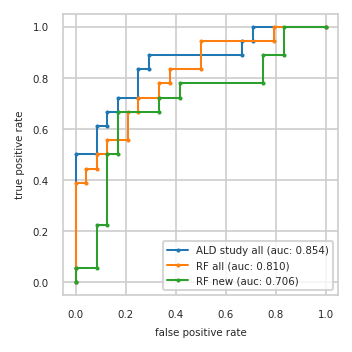

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.389  0.083 0.056
3          0.083 0.500  0.042 0.389  0.083 0.222
4          0.083 0.611  0.042 0.444  0.125 0.222
5          0.125 0.611  0.083 0.444  0.125 0.500
6          0.125 0.667  0.083 0.500  0.167 0.500
7          0.167 0.667  0.125 0.500  0.167 0.667
8          0.167 0.722  0.125 0.556  0.333 0.667
9          0.250 0.722  0.208 0.556  0.333 0.722
10         0.250 0.833  0.208 0.667  0.417 0.722
11         0.292 0.833  0.250 0.667  0.417 0.778
12         0.292 0.889  0.250 0.722  0.750 0.778
13         0.667 0.889  0.333 0.722  0.750 0.889
14         0.667 0.944  0.333 0.778  0.833 0.889
15         0.708 0.944  0.375 0.778  0.833 1.000
16         0.708 1.000  0.375 0.833  1.000 1.000
17         1.000 1.000  0.500 0.833    NaN   NaN
18           NaN   NaN  0.500 0.944    NaN   NaN
19           NaN   NaN  0.792 0.944    NaN   NaN
20           NaN   NaN  0.792 1.000    NaN   NaN
21           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,Q9NY97;Q9NY97-2,Q8TEA8
2,P04114,P08670,P31150
3,P61981,Q9Y2T3;Q9Y2T3-3,A0A0J9YW36;Q9NZ72;Q9NZ72-2
4,P14174,A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16...,E9PK25;G3V1A4;P23528
5,P04075,P04075,P31321
6,Q9Y2T3;Q9Y2T3-3,P14174,Q96GD0
7,P00338;P00338-3,P08253,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,None,P61981,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


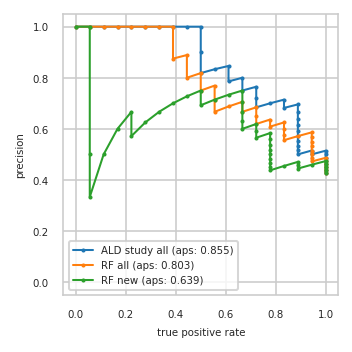

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.472 0.944     0.444 0.889
7          0.514 1.000     0.486 0.944     0.457 0.889
8          0.500 0.944     0.500 0.944     0.471 0.889
9          0.515 0.944     0.515 0.944     0.455 0.833
10         0.500 0.889     0.531 0.944     0.438 0.778
11         0.516 0.889     0.548 0.944     0.452 0.778
12         0.533 0.889     0.567 0.944     0.467 0.778
13         0.552 0.889     0.586 0.944     0.483 0.778
14         0.571 0.889     0.571 0.889     0.500 0.778
15         0.593 0.889     0.556 0.833     0.519 0.778
16         0.615 0.889     0.577 0.833     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.667 0.889     0.625 0.833     0.583 0.778
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.714 0.833     0.619 0.722     0.619 0.722
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.684 0.722     0.684 0.722     0.632 0.667
24         0.722 0.722     0.667 0.667     0.667 0.667
25         0.765 0.722     0.706 0.667     0.706 0.667
26         0.750 0.667     0.688 0.611     0.750 0.667
27         0.800 0.667     0.667 0.556     0.733 0.611
28         0.786 0.611     0.714 0.556     0.714 0.556
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.833 0.556     0.750 0.500     0.750 0.500
31         0.818 0.500     0.818 0.500     0.727 0.444
32         0.900 0.500     0.800 0.444     0.700 0.389
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


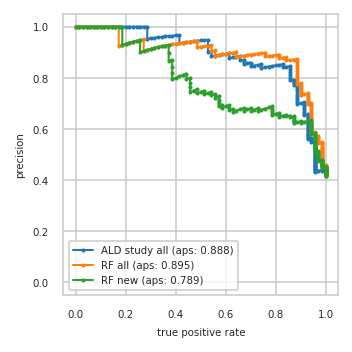

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


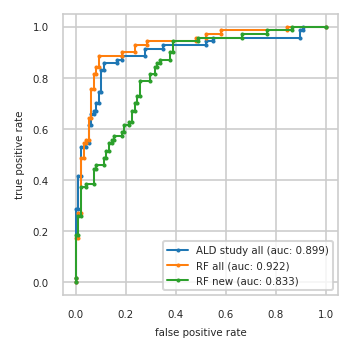

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}